In [1]:
import numpy as np
import sympy as sym 
import pandas as pd

import scipy.integrate
import matplotlib.pyplot as plt

from itertools import permutations

# Five state models

## Combinatorial state generation

In [2]:
## Enumerate state sequences and associated transitions
bound_states = ['RB', 'RN', 'RP', 'RW']
full_states = bound_states + ['R', 'N', 'P', 'W']

transitions_list = []
sequence_list = list(permutations(bound_states))

state_ids = {k: v for v, k in enumerate(full_states)}
state_symbols = {k: sym.symbols(k) for k in full_states}

for sequence in sequence_list:
    transitions = [('R', sequence[0])]

    for s1, s2 in zip(sequence[:-1], sequence[1:]):
        transitions.append((s1, s2))
        transitions.append((s2, s1))

    transitions.append((sequence[-1], 'R'))
    transitions_list.append(transitions)

In [3]:
## Work out dynamical equations
rhs_list = []
rate_symbols_list = []

for transitions in transitions_list:
    rhs = sym.zeros(len(state_symbols), 1)
    rate_symbols = {(s1, s2): sym.symbols('k_%s%s' % (s1[-1], s2[-1])) for s1, s2 in transitions}

    for s1, s2 in transitions:        
        if s2[-1] not in ['R', 'B']:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]

        else:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1]

    rhs[state_ids['N']] = -rhs[state_ids['RN']]
    rhs[state_ids['P']] = -rhs[state_ids['RP']]
    rhs[state_ids['W']] = -rhs[state_ids['RW']]

    rhs_list.append(rhs)
    rate_symbols_list.append(rate_symbols)


## Parameter inference

In [4]:
biophys_df = pd.read_csv('biophysical_params_WT.csv', comment='#')#, delimiter=',')#,quotechar='"')

parameter_dict = dict(zip(biophys_df['parameter'].values, biophys_df['value'].values))

In [5]:
## Set parameters and variables
parameters = sym.symbols(list(parameter_dict.keys()))
tau_N, F_N, N_N, tau_P, F_P, N_P, tau_W, F_W, N_W, tau_R, F_R, N_R = parameters

variables = state_symbols.values()
RB, RN, RP, RW, R, N, P, W = variables

In [6]:
## Set substitution dictionaries for equilibrium concentrations
subs_dict = {'RB': N_R * F_R - N_N * F_N - N_P * F_P - N_W * F_W,
             'RN': N_N * F_N,
             'RP': N_P * F_P,
             'RW': N_W * F_W,
             'R': N_R * (1 - F_R),   
             'N': N_N * (1 - F_N),
             'P': N_P * (1 - F_P),
             'W': N_W * (1 - F_W)}

subs_R = {k: v for k, v in subs_dict.items() if k not in ['R']}
subs_N = {k: v for k, v in subs_dict.items() if k not in ['N', 'RN']}
subs_P = {k: v for k, v in subs_dict.items() if k not in ['P', 'RP']}
subs_W = {k: v for k, v in subs_dict.items() if k not in ['W', 'RW']}

In [7]:
## Map cohesin transition rates to PDS5/WAPL/NIPBL/PDS5 measurements
rate_dict_list = []

for i, rhs in enumerate(rhs_list):
    rate_dict = {}

    rate_symbols = rate_symbols_list[i]
    rhs_eq = sym.zeros(len(rate_symbols), 1)

    eq_R = rhs[state_ids['R']].subs(subs_R)
    eq_N = rhs[state_ids['N']].subs(subs_N)
    eq_P = rhs[state_ids['P']].subs(subs_P)
    eq_W = rhs[state_ids['W']].subs(subs_W)

    # Equilibrium subunit bound fractions
    rhs_eq[state_ids['R']] = sym.collect(eq_R, R).coeff(R, 1) + 1/tau_R * F_R / (1-F_R)
    rhs_eq[state_ids['N']] = sym.collect(eq_N, N).coeff(N, 1) + 1/tau_N * F_N / (1-F_N)
    rhs_eq[state_ids['P']] = sym.collect(eq_P, P).coeff(P, 1) + 1/tau_P * F_P / (1-F_P)
    rhs_eq[state_ids['W']] = sym.collect(eq_W, W).coeff(W, 1) + 1/tau_W * F_W / (1-F_W)

    # Equilibrium subunit residence times
    rhs_eq[state_ids['RB']] = sym.collect(eq_R, R).coeff(R, 0) - N_R*F_R/tau_R
    rhs_eq[state_ids['RN']] = sym.collect(eq_N, RN).coeff(RN, 1) - 1/tau_N
    rhs_eq[state_ids['RP']] = sym.collect(eq_P, RP).coeff(RP, 1) - 1/tau_P
    rhs_eq[state_ids['RW']] = sym.collect(eq_W, RW).coeff(RW, 1) - 1/tau_W

    sol_rates = sym.solve(rhs_eq, *rate_symbols.values())

    for rate, expr in sol_rates.items():
        value = expr.evalf(subs=parameter_dict)
        rate_dict[str(rate)] = value

    rate_dict_list.append(rate_dict)


## Time integration

In [8]:
## Set initial state and integration time interval
init_state = sym.Matrix([[0, 0, 0, 0, # Starting from completely unbound population of RAD21
                          N_R, N_N, N_P, N_W]]) # Degrons can now be simulated by updating protein levels directly from init_state

t = sym.symbols('t') 
t_eval = np.linspace(0, 60 * 60, 500) # evaluate integral from t = 0-60 minutes for 500 points

tspan = (t_eval[0], t_eval[-1])

In [9]:
# pertubation = [perturb_param, perturb_ratio, conditions={state_ratio:direction}]
perturbations = [
    ['N_W', 1/5, {'F_R':'>1'}], #RP shouldn't go down too much according to Wutz Immunoblot. 0.5 chosen arbitrarily.
    ['N_P', 1/5, {'F_R':'>1'}],  #F_R goes up in dPDS5: Wutz
    ['N_N', 1/5, {'F_R':'<1'}],  #F_R goes down in dNIPBL: Haarhuis2017 Fig4E,  Quantitative immunofluorescence 
]

In [10]:
def relative_bound(parameter_dict_mut, final_state_mut, parameter_dict_wt, final_state_wt ):
    mut_bound = (parameter_dict_mut['N_R']-final_state_mut[state_ids['R']]) 
    wt_bound =  (parameter_dict['N_R']-final_state_wt[state_ids['R']])
    return mut_bound / wt_bound

In [11]:
# Enumerate all models satisfying mutant experimental constraints
candidate_list = []
verbose = False

for i, rhs in enumerate(rhs_list):
    sequence = sequence_list[i]
    rate_dict = rate_dict_list[i]

    compute_kinetics = True
    for rate, value in rate_dict.items():
        if value < 0:  compute_kinetics = False
            
    if compute_kinetics:
        rhs_eval = list(rhs.evalf(subs=rate_dict))
        y0_wt = list(init_state.evalf(subs=parameter_dict))
        
        f = sym.lambdify((t, variables), rhs_eval)
        solution = scipy.integrate.solve_ivp(f, tspan, y0_wt, t_eval=t_eval)
        final_state_wt = solution.y[:,-1].copy()

        check_list = []
        for perturbation in perturbations:
            perturbation_param, perturbation_ratio, consequences = perturbation
            parameter_dict_mut = parameter_dict.copy()
            parameter_dict_mut[perturbation_param] *= perturbation_ratio

            y0_mut = list(init_state.evalf(subs=parameter_dict_mut))
            solution = scipy.integrate.solve_ivp(f, tspan, y0_mut, t_eval=t_eval)

            final_state_mut = solution.y[:,-1].copy()

            for consequence in consequences.items():
                if consequence[0] == 'F_R':
                    ratio = relative_bound(parameter_dict_mut, final_state_mut, parameter_dict, final_state_wt)
                elif consequence[0] in state_symbols:
                    ratio = final_state_mut[state_ids[consequence[0]]] / final_state_wt[state_ids[consequence[0]]]
                else:
                    raise ValueError('perturbation consequence not in know state symbols')
                check_list.append( eval(f"{ratio} {consequence[1]}"))
        
        if verbose: print(check_list)
        if np.array(check_list).all():
            candidate_list.append(sequence)

print(candidate_list)


[('RN', 'RB', 'RP', 'RW')]


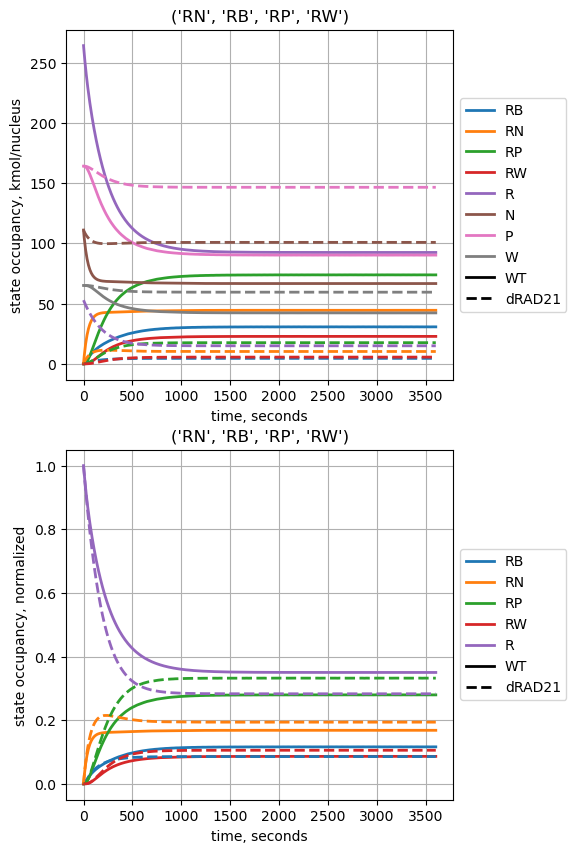

In [12]:
figwidth = 5
final_states = []

for sequence in candidate_list:
    i = sequence_list.index(sequence)

    rhs = rhs_list[i]    
    rate_dict = rate_dict_list[i]

    rhs_eval = list(rhs.evalf(subs=rate_dict))
    y0_wt = list(init_state.evalf(subs=parameter_dict))
        
    f = sym.lambdify((t, variables), rhs_eval)
    solution = scipy.integrate.solve_ivp(f, tspan, y0_wt, t_eval=t_eval)

    parameter_dict_dRAD21 = parameter_dict.copy()
    parameter_dict_dRAD21['N_R'] /= 5

    y0_dRAD21 = list(init_state.evalf(subs=parameter_dict_dRAD21))
    solution_dRAD21 = scipy.integrate.solve_ivp(f, tspan, y0_dRAD21, t_eval=t_eval)

    fig = plt.figure(figsize=(figwidth, 2*figwidth)) 
    ax = plt.subplot(2,1,1)

    ax.set_prop_cycle('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])

    plt.plot(t_eval, solution.y.T, lw=2) 

    plt.plot([], [], 'k', lw=2) 
    plt.plot([], [], 'k--', lw=2) 

    plt.plot(t_eval, solution_dRAD21.y.T, ls='--', lw=2) 

    ax.legend(list(variables)+['WT', 'dRAD21'], shadow=False,
              loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(sequence)

    plt.grid(True)

    _ = plt.xlabel('time, seconds')
    _ = plt.ylabel('state occupancy, kmol/nucleus')

    ax = plt.subplot(2,1,2)

    ax.set_prop_cycle('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

    plt.plot(t_eval, solution.y[:5].T / parameter_dict['N_R'], lw=2) 

    plt.plot([], [], 'k', lw=2) 
    plt.plot([], [], 'k--', lw=2) 

    plt.plot(t_eval, solution_dRAD21.y[:5].T / parameter_dict_dRAD21['N_R'], ls='--', lw=2) 

    ax.legend(list(variables)[:5]+['WT', 'dRAD21'], shadow=False,
              loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(sequence)

    plt.grid(True)

    _ = plt.xlabel('time, seconds')
    _ = plt.ylabel('state occupancy, normalized')

    final_states.append(solution.y[:, -1])


In [13]:
variable_list = list(map(str, variables))

for j, sequence in enumerate(candidate_list):
    print(sequence)
    i = sequence_list.index(sequence)

    rate_dict = rate_dict_list[i]
    final_state = final_states[j]
    
    for rate, value in rate_dict.items():
        if rate[-1] not in ['R', 'B']:
            k = variable_list.index(rate[-1])
            print(f"{rate[:1]}^*{rate[1:]}" + ": %f" % (value * final_state[k]))
        
        else:
            print(rate + ": %f" % value)

('RN', 'RB', 'RP', 'RW')
k^*_BN: 0.013309
k^*_BP: 0.024716
k_NB: 0.013889
k_PB: 0.007435
k^*_PW: 0.006850
k^*_RN: 0.002259
k^*_WP: 0.013047
k_WR: 0.009176
